In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

In [2]:
cols = ['English', 'Hindi', 'annotations']
df = pd.read_csv('data/hin-eng/hin.txt', delimiter='\t', header=None, names = cols)
df.head()

,English,Hindi,annotations
0,Wow!,वाह!,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
1,Duck!,झुको!,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
2,Duck!,बतख़!,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
3,Help!,बचाओ!,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
4,Jump.,उछलो.,CC-BY 2.0 (France) Attribution: tatoeba.org #6...


# Preprocess
We will do a simple preprocess of removing the punctuations and making the words in the lower case

In [3]:
import string
def preprocess(x):
    removed_str = x.translate(str.maketrans('', '', string.punctuation))
    return removed_str.lower()

In [4]:
df['English'] = df['English'].apply(preprocess)
df['Hindi'] = df['Hindi'].apply(preprocess)

In [5]:
df.head()

,English,Hindi,annotations
0,wow,वाह,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
1,duck,झुको,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
2,duck,बतख़,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
3,help,बचाओ,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
4,jump,उछलो,CC-BY 2.0 (France) Attribution: tatoeba.org #6...


# Vocab
Next would be to create a dictionary mapping from word to idx for both English and Hindi

In [6]:
def create_vocab(series_):
    sent = list(map(str.split, series_))
    flatten_sent = [word for i in sent for word in i]
    words = sorted(list(set(flatten_sent)))
    vocab = {word: idx for idx, word in enumerate(words)}
    return vocab

In [7]:
english_vocab = create_vocab(df['English'])
english_vocab['PAD'] = len(english_vocab)
english_vocab['START'] = len(english_vocab)
english_vocab['END'] = len(english_vocab)

In [8]:
hindi_vocab = create_vocab(df['Hindi'])
hindi_vocab['PAD'] = len(hindi_vocab)
hindi_vocab['START'] = len(hindi_vocab)
hindi_vocab['END'] = len(hindi_vocab)

In [9]:
print("number of words in hindi :   ", len(hindi_vocab))
print("number of words in english : ", len(english_vocab))

number of words in hindi :    3063
number of words in english :  2406


Let's save the vocab so that we can reuse them

In [10]:
import pickle

def save_vocab(vocab, file, save_dir = 'data/hin-eng/'):
    with open(f'{save_dir}{file}.pkl', 'wb') as file:
        pickle.dump(vocab, file)
        
save_vocab(english_vocab, 'english_vocab')  
save_vocab(hindi_vocab, 'hindi_vocab')  

# Dataset

In [11]:
def load_vocab(file, save_dir = 'data/hin-eng/'):
    with open(f'{save_dir}{file}.pkl', 'rb') as file:
        vocab = pickle.load(file)
    return vocab

english_vocab = load_vocab('english_vocab')
hindi_vocab = load_vocab('hindi_vocab')

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader

In [13]:
class EnglishHindi(Dataset):
    def __init__(self, file_name, english_vocab, hindi_vocab, sentence_length = 10):
        super().__init__()
        self.english_vocab = english_vocab
        self.hindi_vocab = hindi_vocab
        self.sentence_length = sentence_length
        
        self.x, self.y = [], []
        self.load(file_name)
    
    def load(self, file_name):
        def preprocess(x):
            removed_str = x.translate(str.maketrans('', '', string.punctuation))
            removed_str = str.split(removed_str.lower())
            removed_str = ['START']+removed_str+['END']
            if len(removed_str) < self.sentence_length:
                removed_str = removed_str + ['PAD' for _ in range(self.sentence_length - len(removed_str))]
            removed_str = removed_str[:self.sentence_length]
            return removed_str

        def mask_pad(x):
            mask_ = [(0 if i == 'PAD' else 1) for i in x]
            return mask_
        
        cols = ['English', 'Hindi', 'annotations']
        df = pd.read_csv(f'data/hin-eng/{file_name}', delimiter='\t', header=None, names = cols)
        
        df['English'] = df['English'].apply(preprocess)
        df['Hindi'] = df['Hindi'].apply(preprocess)

        df['EnglishMask'] = df['English'].apply(mask_pad)
        df['HindiMask'] = df['Hindi'].apply(mask_pad)

        df['English'] = df['English'].apply(lambda x : [self.english_vocab[i] for i in x])
        df['Hindi'] = df['Hindi'].apply(lambda x : [self.hindi_vocab[i] for i in x])

        self.x, self.y = list(df['English']), list(df['Hindi'])
        self.mask_x, self.mask_y = list(df['EnglishMask']), list(df['HindiMask'])


    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x = torch.tensor(self.x[idx], dtype=torch.long) 
        y = torch.tensor(self.y[idx], dtype=torch.long)
        mask_x = torch.tensor(self.mask_x[idx], dtype=torch.long)
        mask_y = torch.tensor(self.mask_y[idx], dtype=torch.long)
        return x, y, mask_x, mask_y

In [14]:
file_name = 'hin.txt'
dataset = EnglishHindi(file_name, english_vocab, hindi_vocab)

In [15]:
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [16]:
x, y, mask_x, mask_y = next(iter(dataloader))

# Model

In [17]:
import torch.nn as nn
import torch.nn.functional as F

In [18]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.normalization_factor = d**0.5

    def forward(self, q, k, v, mask = None):
        unnormalized = F.softmax(torch.matmul(q, torch.transpose(k, -2, -1)), dim = -1)
        normalized = unnormalized / self.normalization_factor 
        if (mask is not None):
            normalized = torch.mul(mask, normalized)
        attention_value = torch.matmul(normalized, v) 
        return attention_value, normalized

class Attention(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super().__init__()

        self.query_weights = nn.Linear(input_dim, embedding_dim)
        self.key_weights = nn.Linear(input_dim, embedding_dim)
        self.value_weights = nn.Linear(input_dim, embedding_dim)

        self.scaled_attention = ScaledDotProductAttention(embedding_dim)

    def forward(self, q, k, v, mask = False):
        q = self.query_weights(q)
        k = self.key_weights(k) 
        v = self.value_weights(v)

        attention, attention_weights = self.scaled_attention(q, k, v, mask = mask)
        return attention, attention_weights

class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim, num_heads, embedding_dim, output_dim):
        super().__init__()
        assert (embedding_dim % num_heads == 0), f"embedding dim {embedding_dim} must be divisible by num heads {num_heads}"
        
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.embedding_dim = embedding_dim // num_heads
        self.multihead_attention = nn.ModuleList([
                                    (Attention(input_dim, self.embedding_dim)) for _ in range(num_heads)])

        self.output_projection = nn.Linear(embedding_dim, output_dim)
    
    def forward(self, q, k, v, mask=False):
        attention_list, weights_list = [], []
        for attention_head in self.multihead_attention:
            attention, attention_weights = attention_head(q, k, v, mask)
            attention_list.append(attention)
            weights_list.append(attention_weights.unsqueeze(dim = 1))
        
        attention = torch.cat(attention_list, dim = -1)
        weights_list = torch.cat(weights_list, dim = 1)
        attention = self.output_projection(attention)
        return attention, weights_list

class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, output_dim, num_heads):
        super().__init__()
        self.multi_head_attn = MultiHeadAttention(input_dim, num_heads, 
                                                  embedding_dim, 
                                                  output_dim)
        self.layer_norm_inter = nn.LayerNorm(output_dim)
        self.fc = nn.Sequential(*[
            nn.Linear(output_dim, output_dim),
            nn.ReLU(),
            nn.Linear(output_dim, output_dim),
        ])
        self.layer_norm_final = nn.LayerNorm(output_dim)

    def forward(self, x, mask=False):
        attn, attn_weights = self.multi_head_attn(x, x, x, mask = mask)
        x = x + attn
        x = self.layer_norm_inter(x)
        fc_result = self.fc(x)
        x = self.layer_norm_final(fc_result + x)
        return x, attn_weights

class Decoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, output_dim, num_heads):
        super().__init__()
        self.multi_head_attn_1 = MultiHeadAttention(input_dim, num_heads, 
                                                  embedding_dim, 
                                                  output_dim)
        self.layer_norm_1 = nn.LayerNorm(output_dim)
        self.multi_head_attn_2 = MultiHeadAttention(output_dim, num_heads, 
                                                    output_dim, 
                                                    output_dim)
        self.layer_norm_2 = nn.LayerNorm(output_dim)
        self.fc = nn.Sequential(*[
            nn.Linear(output_dim, output_dim), 
            nn.ReLU(), 
            nn.Linear(output_dim, output_dim)
        ])
        self.layer_norm_final = nn.LayerNorm(output_dim)

    def forward(self, x, encoder, mask_enc = None, mask_dec = None):
        attn, attn_weights_dec = self.multi_head_attn_1(x, x, x, mask = mask_dec)
        x = self.layer_norm_1(x + attn)
        attn, attn_weights_enc = self.multi_head_attn_2(x, encoder, encoder, mask = mask_enc)
        x = self.layer_norm_2(x + attn)
        x = self.fc(x)
        x = self.layer_norm_final(x)
        return x, attn_weights_enc, attn_weights_dec

In [19]:
class Transformer(nn.Module):
    def __init__(self, input_vocab_size, output_vocab_size, 
                 input_dim, embedding_dim, output_dim, num_heads):
        super().__init__()
        self.input_dim = input_dim
        self.input_embeddings = nn.Embedding(input_vocab_size, input_dim)
        self.output_embeddings = nn.Embedding(output_vocab_size, input_dim)
        
        self.encoder_1 = Encoder(input_dim, embedding_dim, embedding_dim, num_heads)
        self.decoder_1 = Decoder(input_dim, embedding_dim, embedding_dim, num_heads)

        self.encoder_2 = Encoder(input_dim, embedding_dim, embedding_dim, num_heads)
        self.decoder_2 = Decoder(input_dim, embedding_dim, embedding_dim, num_heads)

        self.encoder_3 = Encoder(input_dim, embedding_dim, embedding_dim, num_heads)
        self.decoder_3 = Decoder(input_dim, embedding_dim, embedding_dim, num_heads)

        self.fc_connect = nn.Sequential(*[
            nn.Linear(embedding_dim, embedding_dim), 
            nn.ReLU(), 
            nn.Linear(embedding_dim, output_dim)
        ])        

        self.positional_embedding = self.get_positional_embedding()

    def get_positional_embedding(self, sequence_length=10):
        d = self.input_dim
        i = np.arange(0,d//2)
        positional_embedding = []
        for pos in range(sequence_length):
            positional_embedding.append(
                      np.concatenate([np.sin(pos/(10000**((2*i)/d))), 
                                      np.cos(pos/(10000**((2*i+1)/d)))]))
        positional_embedding = np.array(positional_embedding)
        positional_embedding = torch.tensor(positional_embedding, dtype=torch.float32)
        return positional_embedding
    
    def forward(self, x, outputs, mask_x):
        x = self.input_embeddings(x)
        outputs = self.output_embeddings(outputs)
        
        positional_embedding = self.positional_embedding.unsqueeze(0).expand(x.size(0), x.size(1), x.size(2))
        positional_embedding = positional_embedding.to(x.device)

        mask_x = torch.transpose(mask_x.unsqueeze(2).expand(x.size(0),x.size(1),x.size(1)), -2,-1)
        
        x = x+positional_embedding
        
        enc_1, _ = self.encoder_1(x, mask = mask_x)
        enc_2, _ = self.encoder_2(enc_1, mask = mask_x)
        enc_3, _ = self.encoder_3(enc_2, mask = mask_x) # shape [batch_size x seq_len x output_dim]

        # we need to add the last sequence of the encoder to initial sequence
        h = enc_3[:, -1].unsqueeze(1)  # shape [batch_size x 1 x output_dim]
        outputs = outputs[:, : -1]
        outputs = torch.cat([h, outputs], dim = -2)

        mask_y = torch.tril(torch.ones(size=(x.size(1),x.size(1)))).to(x.device)
        decoder_1, _, _ = self.decoder_1(outputs, enc_1, mask_dec = mask_y, mask_enc = mask_x)
        decoder_2, _, _ = self.decoder_2(decoder_1, enc_2, mask_dec = mask_y, mask_enc = mask_x)
        decoder_3, weights_enc, weights_dec = self.decoder_3(decoder_2, enc_3, 
                                                             mask_dec = mask_y, mask_enc = mask_x)

        return self.fc_connect(decoder_3), weights_enc, weights_dec

In [20]:
batch_size = 32

input_dim = 256
embedding_dim = 256
num_heads = 4

output_dim = len(hindi_vocab)
vocab_size = len(english_vocab)

model = Transformer(vocab_size, output_dim, input_dim, embedding_dim, output_dim, num_heads)

In [21]:
device = torch.device('cpu')

model = model.to(device)
optim = torch.optim.Adam(model.parameters(), lr = 1e-4)
loss_fn = nn.CrossEntropyLoss(reduction = 'none')

In [22]:
epochs = 50
history = {'training_loss' : [], 'training_acc':[]}
for epoch in tqdm(range(epochs)):
    loss_ = []
    acc_ = []
    for _, (x, y, mask_x, mask_y) in enumerate(dataloader):
        x, y, mask_x, mask_y = x.to(device), y.to(device), mask_x.to(device), mask_y.to(device)
        pred, _, _ = model(x, y, mask_x)
        pred_, y_  = pred.reshape(-1, pred.size(-1)), y.reshape(-1)
        mask_y = mask_y.reshape(-1)
        
        loss = loss_fn(pred_,y_)
        loss = torch.mul(mask_y, loss).mean()
        acc = (torch.argmax(pred_, dim = -1) == y_).sum() / pred_.size(0)
    
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        loss_.append(loss.item())
        acc_.append(acc.item())

    loss_, acc_ = np.mean(loss_), np.mean(acc_)
    history['training_loss'].append(loss_)
    history['training_acc'].append(acc_)
    print(f"[{epoch}] Loss : {loss_:.4f} Acc : {acc_:.3f}")

  0%|          | 0/50 [00:00<?, ?it/s]

[0] Loss : 4.2613 Acc : 0.218
[1] Loss : 3.4619 Acc : 0.277
[2] Loss : 3.1103 Acc : 0.313
[3] Loss : 2.8426 Acc : 0.342
[4] Loss : 2.6128 Acc : 0.370
[5] Loss : 2.4034 Acc : 0.391
[6] Loss : 2.2058 Acc : 0.416
[7] Loss : 2.0117 Acc : 0.440
[8] Loss : 1.8202 Acc : 0.464
[9] Loss : 1.6391 Acc : 0.489
[10] Loss : 1.4670 Acc : 0.516
[11] Loss : 1.2975 Acc : 0.545
[12] Loss : 1.1409 Acc : 0.572
[13] Loss : 1.0072 Acc : 0.599
[14] Loss : 0.8852 Acc : 0.621
[15] Loss : 0.7881 Acc : 0.639
[16] Loss : 0.6892 Acc : 0.660
[17] Loss : 0.6131 Acc : 0.676
[18] Loss : 0.5373 Acc : 0.693
[19] Loss : 0.4966 Acc : 0.704
[20] Loss : 0.4162 Acc : 0.722
[21] Loss : 0.3747 Acc : 0.731
[22] Loss : 0.3431 Acc : 0.739
[23] Loss : 0.2979 Acc : 0.750
[24] Loss : 0.2619 Acc : 0.758
[25] Loss : 0.2382 Acc : 0.765
[26] Loss : 0.2335 Acc : 0.764
[27] Loss : 0.1907 Acc : 0.777
[28] Loss : 0.1545 Acc : 0.785
[29] Loss : 0.1507 Acc : 0.786
[30] Loss : 0.1870 Acc : 0.774
[31] Loss : 0.1577 Acc : 0.782
[32] Loss : 0.1233

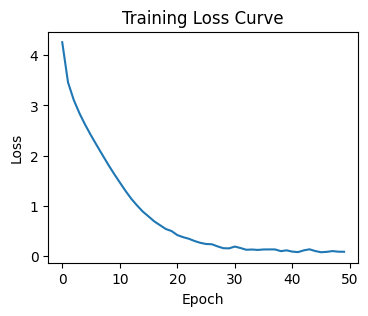

In [23]:
plt.figure(figsize=(4,3))
axs = sns.lineplot(history['training_loss'])
_ = axs.set(xlabel = 'Epoch', ylabel='Loss', title='Training Loss Curve')

In [24]:
hindi_inverted = { hindi_vocab[key] : key for key in hindi_vocab.keys()}
english_inverted = { english_vocab[key] : key for key in english_vocab.keys()}

In [34]:
x_sample, y_sample, mask_x_sample, mask_y_sample = next(iter(dataloader))
pred_sample, weights_enc, weights_dec = model(x_sample, y_sample, mask_x_sample)
t = torch.argmax(pred_sample, dim = -1).detach().numpy()

idx = 0

english_words = [english_inverted[idx] for idx in x_sample.detach().numpy()[idx]]
hindi_words_pred = [hindi_inverted[idx] for idx in t[idx]]
hindi_word_actual = [hindi_inverted[idx] for idx in y_sample[idx].detach().numpy()]

print("English :", [i for i in english_words if i not in ['START', 'END', 'PAD']])
print("Predicted : ", [i for i in hindi_words_pred if i not in ['START', 'END', 'PAD']] )
print("Actual : ", [i for i in hindi_word_actual if i not in ['START', 'END', 'PAD']]  )

English : ['he', 'reads', 'the', 'paper', 'every', 'morning']
Predicted :  ['वह', 'हर', 'सुबह', 'अखबार', 'पढ़ता', 'है।']
Actual :  ['वह', 'हर', 'सुबह', 'अखबार', 'पढ़ता', 'है।']


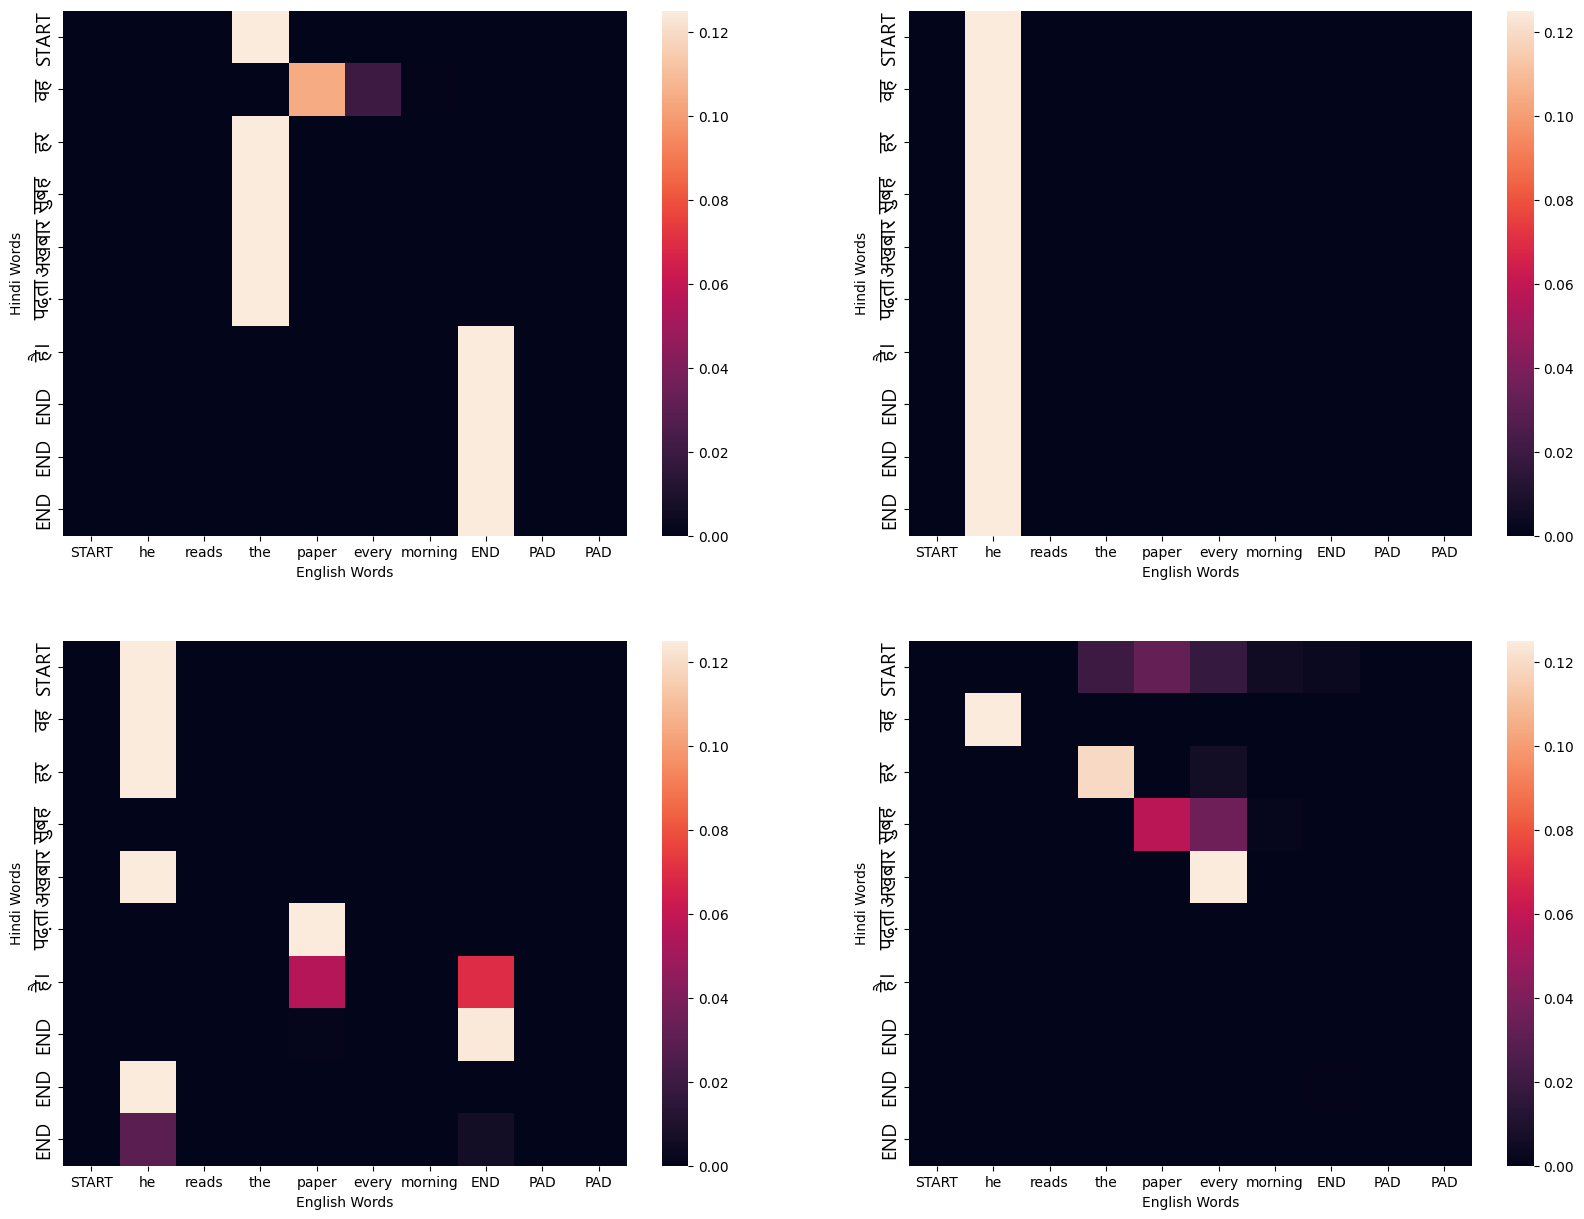

In [35]:
hindi_font = FontProperties(fname='font/Nirmala.ttf', size=14)
_, axs = plt.subplots(2, 2, figsize=(20, 15))
for row in range(2):
    for col in range(2):
        axs[row][col] = sns.heatmap(weights_enc[idx, row*2 + col].detach().numpy(), 
                                    ax =  axs[row][col], cbar=True)
        _ =  axs[row][col].set(xticklabels = english_words , 
                               ylabel = 'Hindi Words', xlabel = 'English Words')
        _ =  axs[row][col].set_yticklabels(hindi_words_pred, 
                                           fontproperties=hindi_font)